📌 Setup: Imports & Configuration




In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from pathlib import Path
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif
import scipy.stats as ss
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Add scripts directory to import path
import sys
sys.path.append('../scripts')
from config import TRAIN_PATH, UNSEEN_PATH, CLEANED_TRAIN, CLEANED_UNSEEN, VISUALS_DIR

logging.basicConfig(level=logging.INFO, format='%(message)s')

🔍 Load Dataset

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
unseen_df = pd.read_csv(UNSEEN_PATH)

X_COLUMNS = train_df.columns.drop('label')
Y_COLUMN = 'label'

🧠 Step 1: Compute Feature Importanc

In [4]:
X = train_df[X_COLUMNS]
y = train_df[Y_COLUMN]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance_Before": rf.feature_importances_
}).sort_values(by="Importance_Before", ascending=False)
importance_df.head()

,Feature,Importance_Before
39,iat,0.491006
34,min,0.049060
35,max,0.038589
0,flow_duration,0.038137
41,magnitude,0.035839


🔗 Step 2: Correlation with Targe

In [5]:
def cramers_v(x, y):
    cmatrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(cmatrix)[0]
    n = cmatrix.sum().sum()
    phi2 = chi2 / n
    r, k = cmatrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1)) if min(k - 1, r - 1) > 0 else 0

def compute_target_correlations(df, target):
    results = {}
    for col in X_COLUMNS:
        if pd.api.types.is_numeric_dtype(df[col]):
            score, _ = f_classif(df[[col]], df[target])
            results[col] = score[0]
        else:
            results[col] = cramers_v(df[col], df[target])
    return pd.DataFrame({"Feature": results.keys(), "Correlation": results.values()}).sort_values(by="Correlation", ascending=False)

correlation_df = compute_target_correlations(train_df, Y_COLUMN)
correlation_df.head()

c:\Users\walid\python\python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\walid\python\python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\walid\python\python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\walid\python\python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\walid\python\python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % cons

,Feature,Correlation
34,min,103297.194021
2,protocol_type,85236.107051
41,magnitude,67207.572988
44,variance,53689.741089
36,avg,41761.919851


🧮 Step 3: Identify Highly Correlated Pair

In [6]:
corr_matrix = train_df[X_COLUMNS].corr()
high_pairs = [(i, j, corr_matrix.loc[i, j])
              for i in corr_matrix.columns
              for j in corr_matrix.columns
              if i != j and abs(corr_matrix.loc[i, j]) > 0.9]
high_pairs[:5]

[('rate', 'srate', 1.0),
 ('srate', 'rate', 1.0),
 ('fin_flag_number', 'rst_flag_number', 0.9750185908824415),
 ('fin_flag_number', 'ack_count', 0.9855452773784146),
 ('rst_flag_number', 'fin_flag_number', 0.9750185908824415)]

✂️ Step 4: Drop Lower Importance Feature from Each Pair


In [7]:
def drop_least_important(pairs, importances):
    drop = set()
    for f1, f2, _ in pairs:
        i1 = importances.loc[importances['Feature'] == f1, 'Importance_Before'].values[0]
        i2 = importances.loc[importances['Feature'] == f2, 'Importance_Before'].values[0]
        drop.add(f2 if i1 > i2 else f1)
    return list(drop)

to_drop = drop_least_important(high_pairs, importance_df)
len(to_drop), to_drop[:5]

(11, ['weight', 'srate', 'number', 'tot_size', 'avg'])

💾 Step 5: Save Cleaned Dataset

In [8]:
df_clean = train_df.drop(columns=to_drop)
df_unseen_clean = unseen_df.drop(columns=to_drop)

df_clean.to_csv(CLEANED_TRAIN, index=False)
df_unseen_clean.to_csv(CLEANED_UNSEEN, index=False)

🔁 Step 6: Recompute Feature Importance

In [9]:
X_clean = df_clean.drop(columns=[Y_COLUMN])
y_clean = df_clean[Y_COLUMN]

rf_clean = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clean.fit(X_clean, y_clean)

clean_imp_df = pd.DataFrame({
    "Feature": X_clean.columns,
    "Importance_After": rf_clean.feature_importances_
})

📊 Step 7: Visualize Feature Correlation Heatmap

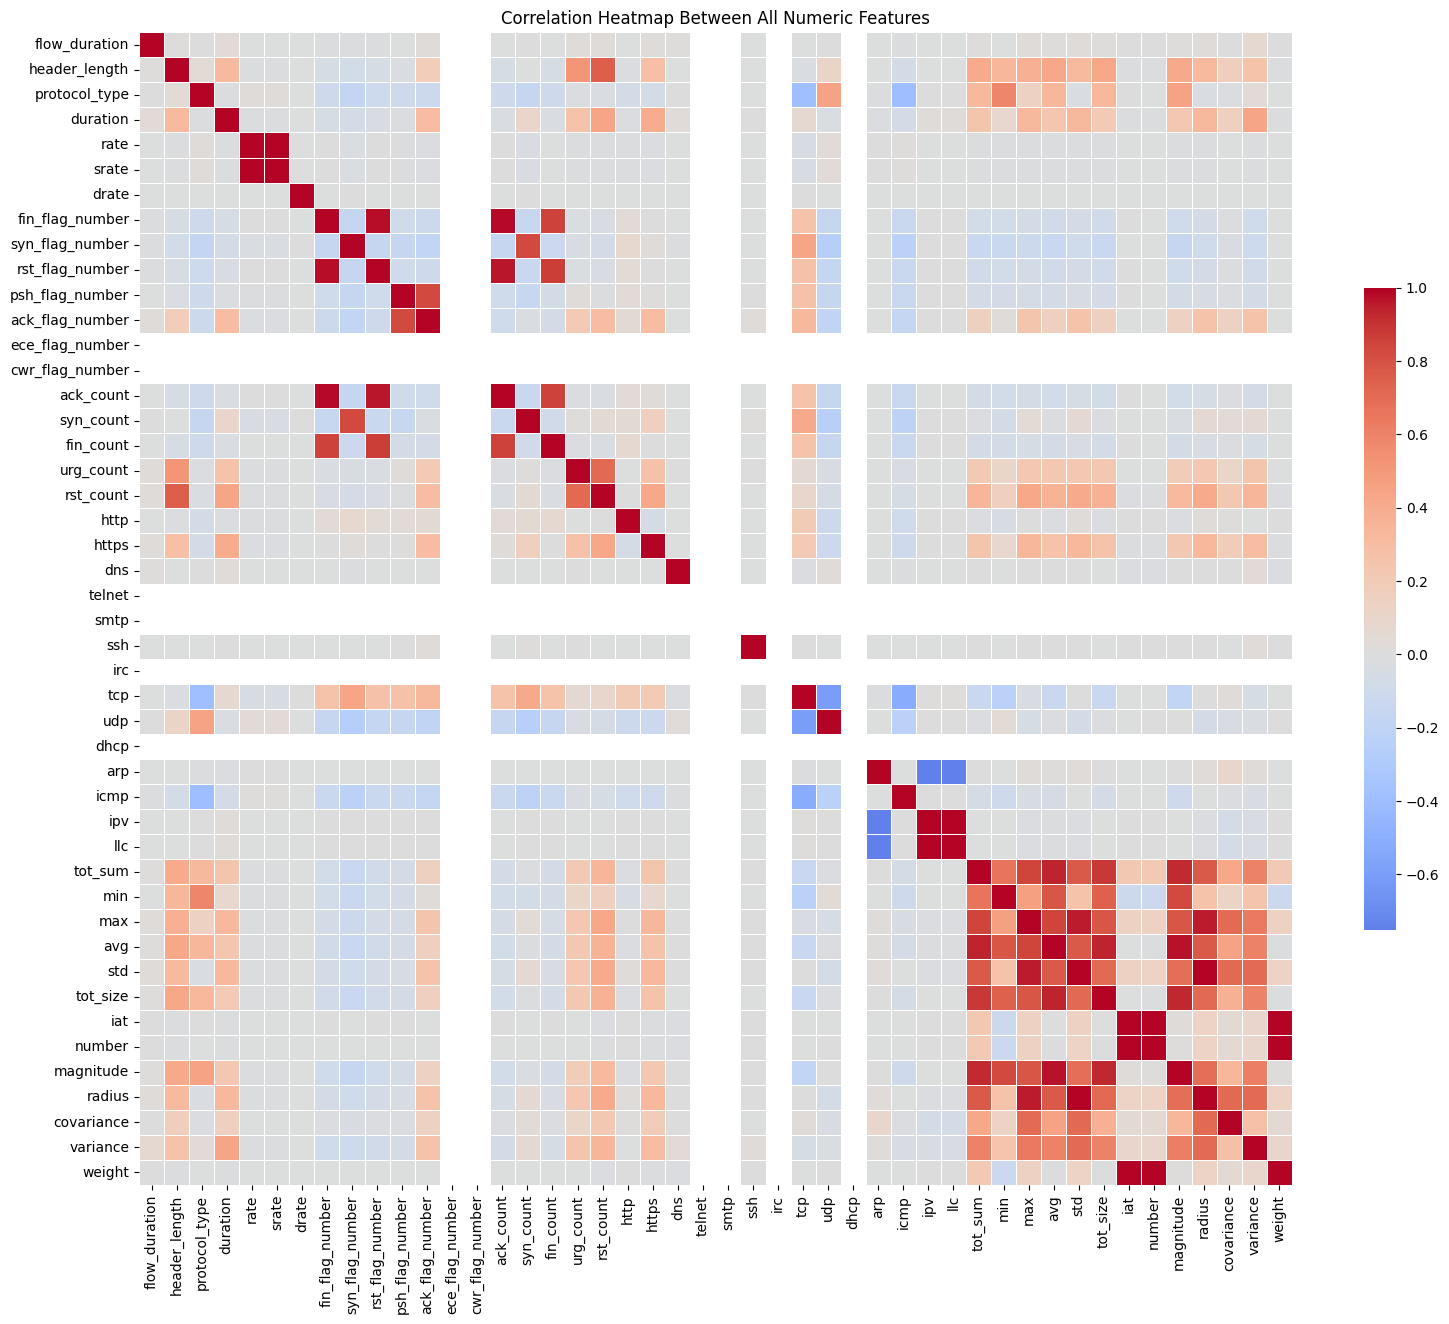

In [15]:
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=False,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.5}
)
plt.title("Correlation Heatmap Between All Numeric Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

📊 Step 8: Visualize Feature Inportance Before Dropping 

C:\Users\walid\AppData\Local\Temp\ipykernel_31004\3888486072.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


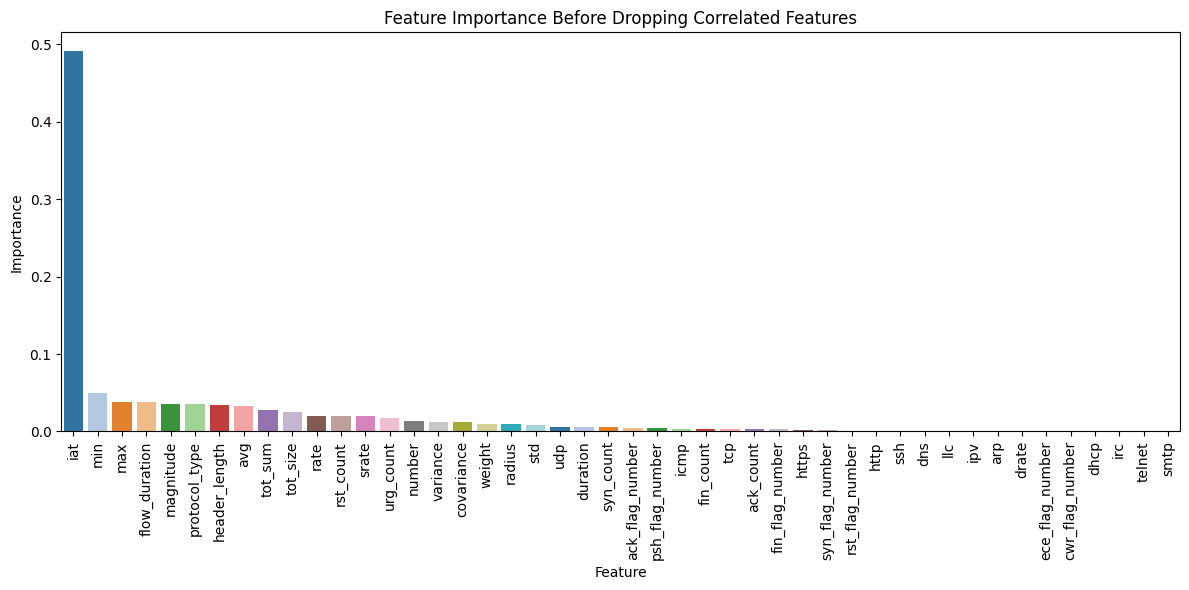

In [13]:
plt.figure(figsize=(max(12, len(importance_df) * 0.25), 6))
sns.barplot(
    data=importance_df.sort_values(by='Importance_Before', ascending=False),
    x='Feature', y='Importance_Before', palette='tab20'
)
plt.title("Feature Importance Before Dropping Correlated Features")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

📊 Step 9: Visual Feature Inportance After Dropping

C:\Users\walid\AppData\Local\Temp\ipykernel_31004\543651404.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


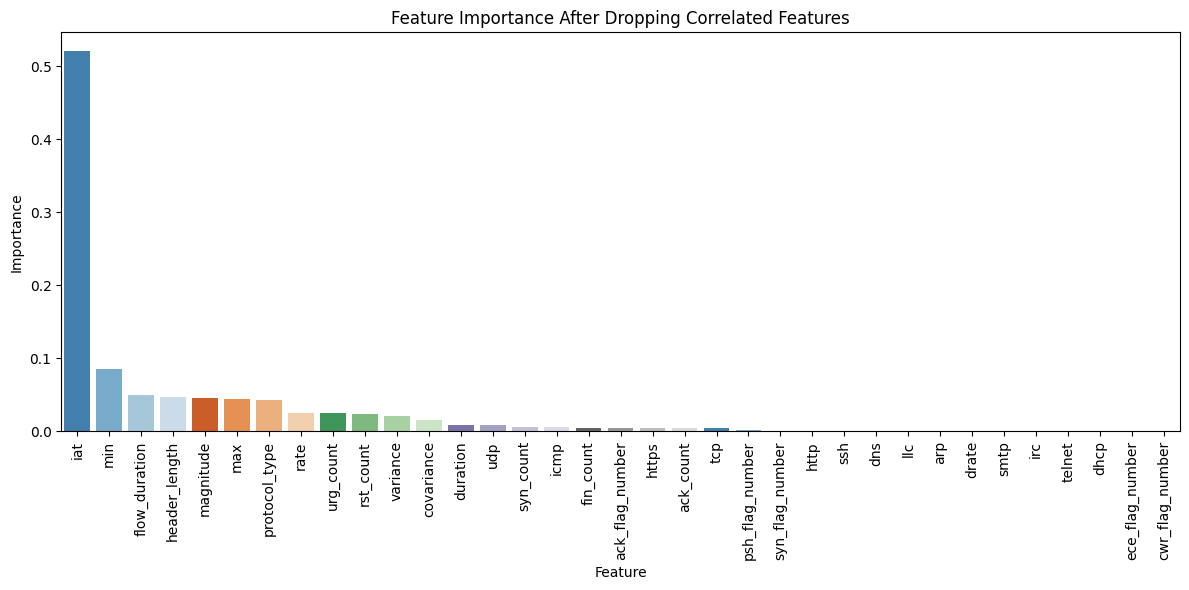

In [14]:
plt.figure(figsize=(max(12, len(clean_imp_df) * 0.25), 6))
sns.barplot(
    data=clean_imp_df.sort_values(by='Importance_After', ascending=False),
    x='Feature', y='Importance_After', palette='tab20c'
)
plt.title("Feature Importance After Dropping Correlated Features")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

📊 Step 10: Visual Comparison Before vs After

C:\Users\walid\AppData\Local\Temp\ipykernel_31004\1912622305.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(merged_df))


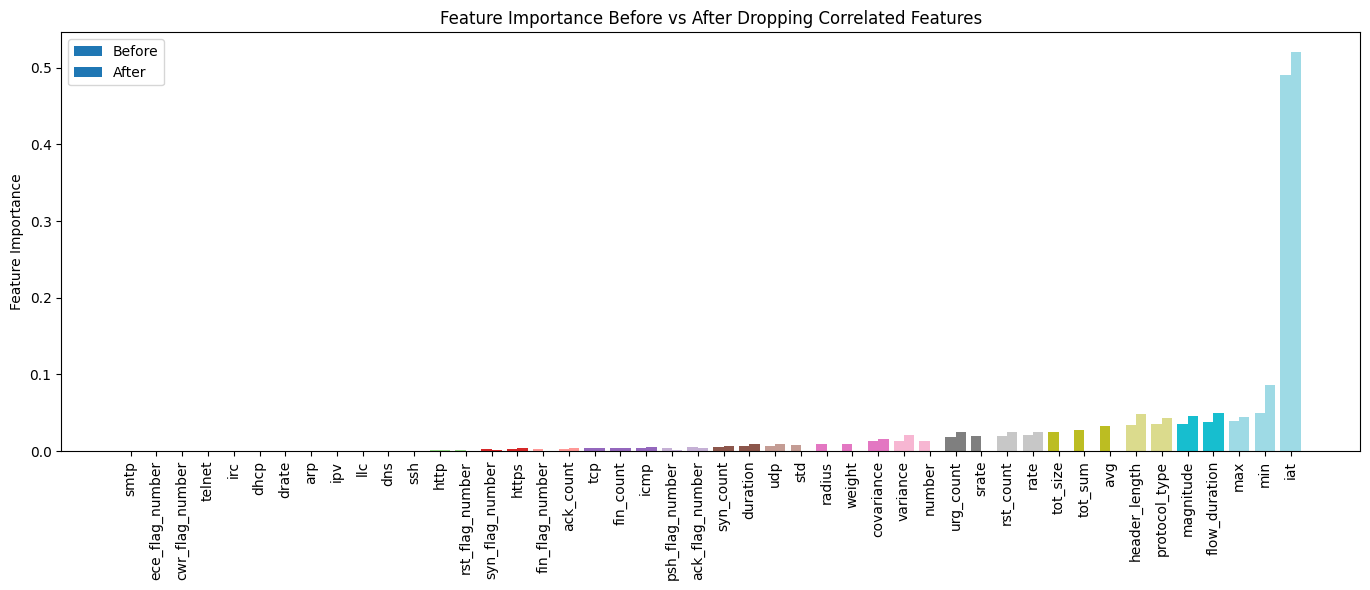

In [12]:
merged_df = importance_df.merge(clean_imp_df, on='Feature', how='outer').fillna(0)
merged_df = merged_df.merge(correlation_df, on='Feature', how='left').fillna(0)
merged_df = merged_df.sort_values(by='Importance_Before', ascending=True)

norm = mcolors.Normalize(vmin=0, vmax=len(merged_df))
colors = cm.get_cmap('tab20', len(merged_df))
x_pos = np.arange(len(merged_df))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(max(12, len(merged_df) * 0.3), 6))
ax.bar(x_pos - bar_width / 2, merged_df['Importance_Before'], width=bar_width,
       color=[colors(i) for i in range(len(merged_df))], label='Before')
ax.bar(x_pos + bar_width / 2, merged_df['Importance_After'], width=bar_width,
       color=[colors(i) for i in range(len(merged_df))], label='After')

ax.set_xticks(x_pos)
ax.set_xticklabels(merged_df['Feature'], rotation=90)
ax.set_ylabel("Feature Importance")
ax.set_title("Feature Importance Before vs After Dropping Correlated Features")
ax.legend()
plt.tight_layout()
plt.show()

📌 Summary


In [16]:
print(f"\n🧹 Dropped {len(to_drop)} features: {to_drop}")
print(f"✅ Cleaned training data saved at: {CLEANED_TRAIN}")
print(f"✅ Cleaned unseen data saved at: {CLEANED_UNSEEN}")


🧹 Dropped 11 features: ['weight', 'srate', 'number', 'tot_size', 'avg', 'rst_flag_number', 'radius', 'std', 'tot_sum', 'ipv', 'fin_flag_number']
✅ Cleaned training data saved at: A:\master\Thesis\Raw_Data\data_process\Data\test\cleaned_data_2.csv
✅ Cleaned unseen data saved at: A:\master\Thesis\Raw_Data\data_process\Data\test\unseen_cleaned.csv
